In [1]:
#importing the required files

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

In [2]:
#setting the data

dateparse = lambda dates: pd.datetime.strptime(dates, '%Y/%m/%d %H:%M:%S')
data_path = 'data.csv'
data = pd.read_csv('data.csv', index_col='SETTLEMENTDATE', date_parser = dateparse)
data.head()

,REGION,TOTALDEMAND,RRP,PERIODTYPE
SETTLEMENTDATE,,,,
2013-01-01 00:30:00,NSW1,7166.97,46.61,TRADE
2013-01-01 01:00:00,NSW1,6928.11,46.32,TRADE
2013-01-01 01:30:00,NSW1,6541.21,44.76,TRADE
2013-01-01 02:00:00,NSW1,6253.60,42.86,TRADE
2013-01-01 02:30:00,NSW1,6003.44,42.86,TRADE


In [3]:
#dropping unnessary data

fields_to_drop = ['REGION', 'PERIODTYPE']
data = data.drop(fields_to_drop, axis = 1)
data.head()

,TOTALDEMAND,RRP
SETTLEMENTDATE,,
2013-01-01 00:30:00,7166.97,46.61
2013-01-01 01:00:00,6928.11,46.32
2013-01-01 01:30:00,6541.21,44.76
2013-01-01 02:00:00,6253.60,42.86
2013-01-01 02:30:00,6003.44,42.86


In [4]:
#making settlement date as the index for the ts data

ts = data['TOTALDEMAND']
ts.head(10)


SETTLEMENTDATE
2013-01-01 00:30:00    7166.97
2013-01-01 01:00:00    6928.11
2013-01-01 01:30:00    6541.21
2013-01-01 02:00:00    6253.60
2013-01-01 02:30:00    6003.44
2013-01-01 03:00:00    5838.95
2013-01-01 03:30:00    5740.95
2013-01-01 04:00:00    5669.57
2013-01-01 04:30:00    5682.72
2013-01-01 05:00:00    5622.05
Name: TOTALDEMAND, dtype: float64

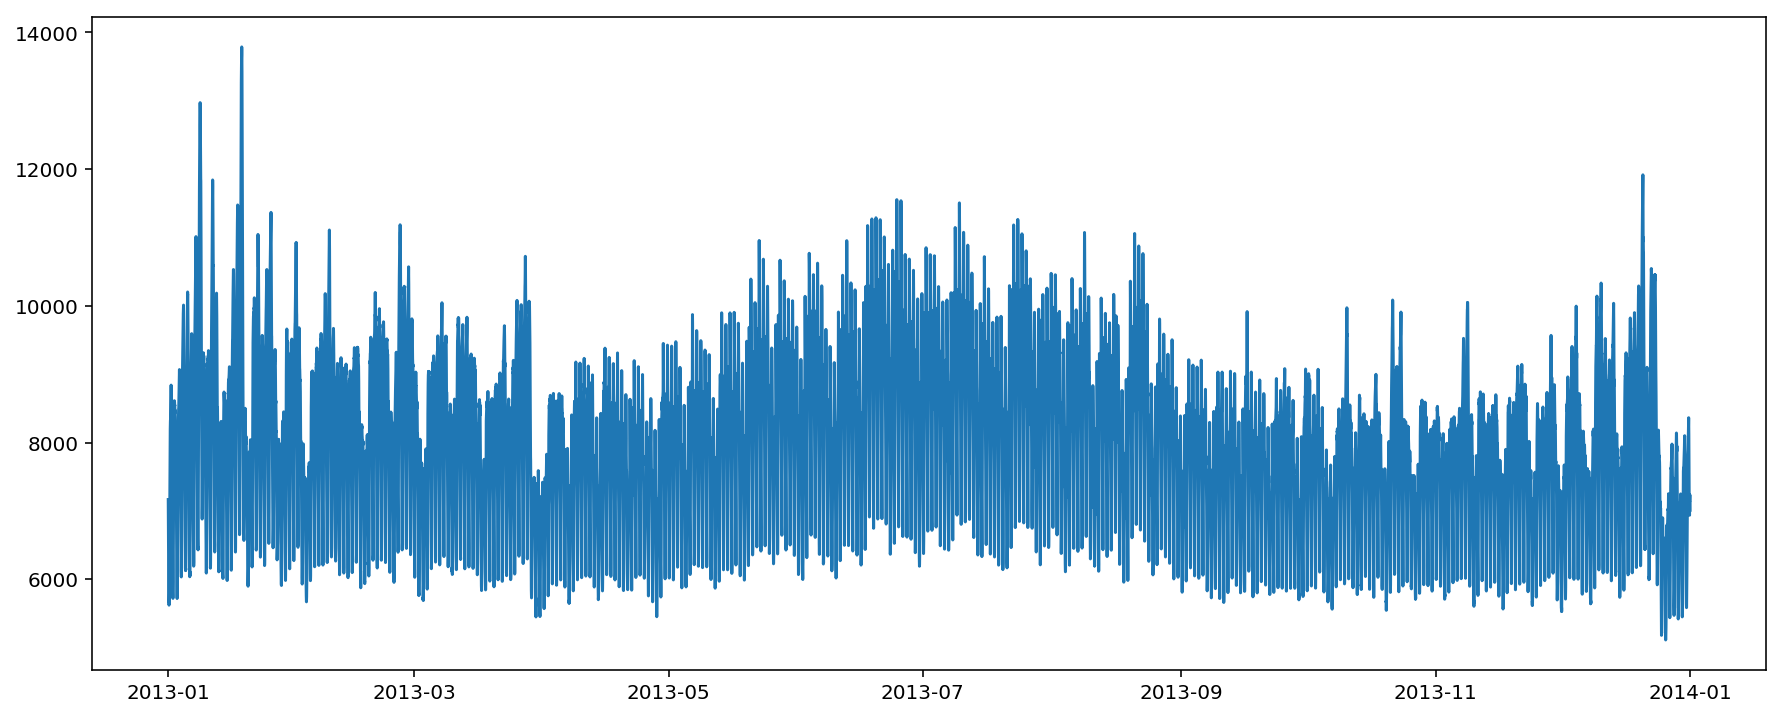

In [5]:
plt.plot(ts)

C:\Users\arpitdec5\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
C:\Users\arpitdec5\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel\__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


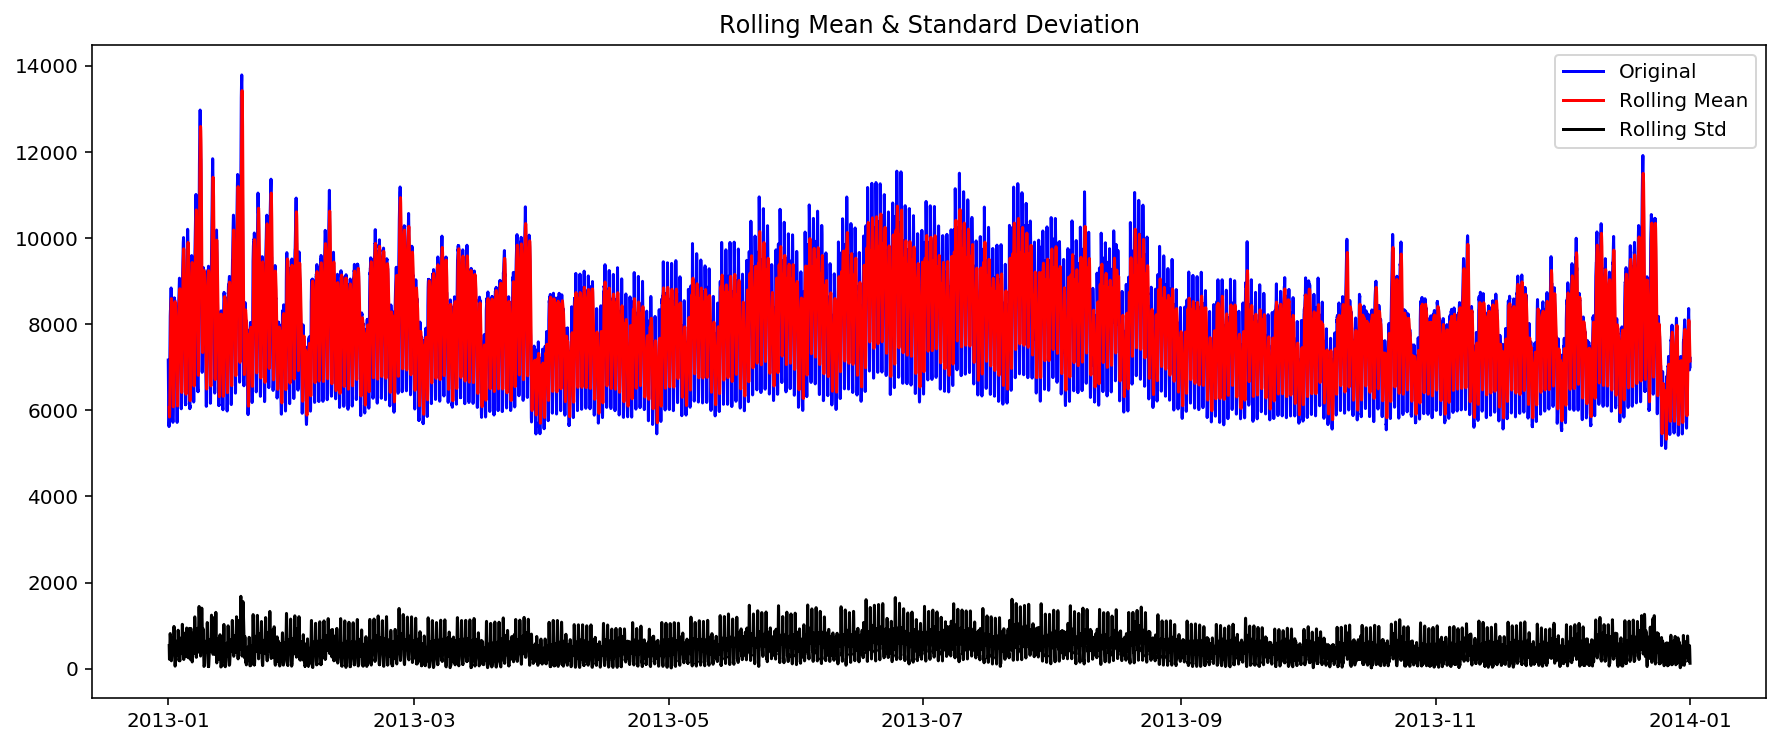

Results of Dickey-Fuller Test:
Test Statistic                    -4.101059
p-value                            0.000965
#Lags Used                        42.000000
Number of Observations Used    17477.000000
Critical Value (10%)              -2.566858
Critical Value (5%)               -2.861705
Critical Value (1%)               -3.430724
dtype: float64


In [7]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

test_stationarity(ts)

In [77]:
#normalizing of input data

quant_features = ['Avg Temperature @ 50m [deg C]', 'Avg Wind Chill Temp [deg C]', 'Avg Dew Point Temp [deg C]', 'Avg Relative Humidity [%]', 'Avg Specific Humidity [g/Kg]', 'Avg Station Pressure [mBar]', 'Avg Sea-Level Pressure (Est) [mBar]', 'Avg Avg Wind Speed @ 50m [m/s]', 'Avg Avg Wind Shear [1/s]', 'Avg Friction Velocity (u*) [m/s]', 'Avg Est Surface Roughness [m]']
scaled_features = {}
for each in quant_features:
    mean, std = rides[each].mean(), rides[each].std()
    scaled_features[each] = [mean, std]
    rides.loc[:, each] = (rides[each] - mean)/std
    
print('Normalization Successful!')

Normalization Successful!


In [86]:
rides.head()

,HOUR-MST,Avg Temperature @ 50m [deg C],Avg Wind Chill Temp [deg C],Avg Dew Point Temp [deg C],Avg Relative Humidity [%],Avg Specific Humidity [g/Kg],Avg Station Pressure [mBar],Avg Sea-Level Pressure (Est) [mBar],Avg Avg Wind Speed @ 50m [m/s],Avg Avg Wind Shear [1/s],Avg Friction Velocity (u*) [m/s],Avg Est Surface Roughness [m]
0,1,9.0479,6.0476,-4.0270,37.5551,3.4108,795.5812,996.7287,10.0032,0.0969,0.4638,0.0227
1,2,9.3083,6.7064,-4.0102,37.3308,3.4164,795.4170,996.5317,8.1895,0.0828,0.4237,0.0544
2,3,9.5555,7.0637,-3.8798,37.6094,3.4558,795.1913,996.2595,7.3753,0.0802,0.4003,0.0938
3,4,9.3960,6.5580,-3.8903,37.8555,3.4547,794.7698,995.7542,8.6625,0.0958,0.4414,0.0437
4,5,8.6223,6.2550,-4.2363,39.2980,3.3559,794.3593,995.2617,5.3785,0.0613,0.2869,0.0651


In [87]:
#dividing data into training, validation and test data

test_data = data[-30*48:]
data = data[:-30*48]

target_fields = ['Avg Avg Wind Speed @ 50m [m/s]']
features, targets = data.drop(target_fields, axis=1), data[target_fields]
test_features, test_targets = test_data.drop(target_fields, axis=1), test_data[target_fields]
n_records = features.shape[0]
split = np.random.choice(features.index, 
                         size=int(n_records*0.8), 
                         replace=False)
train_features, train_targets = features.ix[split], targets.ix[split]
val_features, val_targets = features.drop(split), targets.drop(split)

print('Dividing data into training, validation and testing successful!')

Dividing data into training, validation and testing successful!


In [88]:
#code for rvfl network

#activation functions
def sigmoid(x):
    return 1/ (1 + np.exp(-x))

def relu(x):
    return np.maximum(x, 0, x)
    
def tanh(x):
    return np.tanh(x)

def sine(x):
    return np.sin(x)
    
class NeuralNetwork:
    
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        
        
        self.learning_rate = learning_rate
        self.input_nodes = input_nodes
        self.hidden_nodes = hidden_nodes
        self.output_nodes = output_nodes
        
        #activation function on the outputs of hidden layer
        self.activation_function = sigmoid
        #self.activation_function = relu
        #self.activation_function = tanh
        #self.activation_function = sine
        
        #range of the random weights for input to hidden neurons
        #self.weights_input_to_hidden = np.random.uniform(-0.5, 0.5,(self.hidden_nodes, self.input_nodes))
        self.weights_input_to_hidden = np.random.uniform(0.0, 1.0,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(-1.5, 1.5,(self.hidden_nodes, self.input_nodes))
        #self.weights_input_to_hidden = np.random.uniform(-2.0, 2.0,(self.hidden_nodes, self.input_nodes))
        
        self.weights_hidden_to_output = np.random.normal(0.0, self.output_nodes**-0.5,(self.output_nodes, self.hidden_nodes)) 
        self.biases_output = np.random.normal(0.5, 1.0,(self.output_nodes)) 
        self.weights_input_to_output = np.random.normal(0.0, self.output_nodes**-0.5, (self.output_nodes, self.input_nodes))
    
    def train(self, inputs_list, targets_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        targets = np.array(targets_list, ndmin = 2).T
        
        #forward pass
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) + np.dot(self.weights_input_to_output, inputs) + self.biases_output
        final_outputs = final_inputs
        
        #backward pass
        output_errors = (targets - final_outputs) + (5.0 * np.sum(self.weights_hidden_to_output))/self.weights_hidden_to_output.size
        self.weights_hidden_to_output += self.learning_rate * np.dot(output_errors, hidden_outputs.T)
        self.weights_input_to_output += self.learning_rate * np.dot(output_errors, inputs.T)
        self.biases_output += output_errors[0][0] * self.learning_rate
        
    def run(self, inputs_list):
        
        inputs = np.array(inputs_list, ndmin=2).T
        hidden_inputs = np.dot(self.weights_input_to_hidden, inputs) 
        hidden_outputs = self.activation_function(hidden_inputs)
        final_inputs = np.dot(self.weights_hidden_to_output, hidden_outputs) + np.dot(self.weights_input_to_output, inputs) + self.biases_output
        final_outputs = final_inputs
        return final_outputs

print('RVFL Network created!')

RVFL Network created!


In [89]:
#errors for analyzing the performance of our network on testing data set
def MSE(y, Y):
    return np.mean((y-Y)**2)

def RMSE(y, Y):
    return (np.mean((y-Y)**2))**0.5

def nRMSE(y, Y):
    return ((np.mean((y-Y)**2))**0.5)/np.std(Y)

In [90]:
#training the network

epochs = 1000
learning_rate = 0.01

#varying number of hidden nodes
hidden_nodes = 14
#hidden_nodes = 15
#hidden_nodes = 20

output_nodes = 1

N_i = train_features.shape[1]
network = NeuralNetwork(N_i, hidden_nodes, output_nodes, learning_rate)

losses = {'train':[], 'validation':[]}
for e in range(epochs):
    
    batch = np.random.choice(train_features.index, size=128)
    for record, target in zip(train_features.ix[batch].values, train_targets.ix[batch]['Avg Avg Wind Speed @ 50m [m/s]']):
        network.train(record, target)
    if e%(epochs/10) == 0:
        
        train_loss = MSE(network.run(train_features), train_targets['Avg Avg Wind Speed @ 50m [m/s]'].values)
        val_loss = MSE(network.run(val_features), val_targets['Avg Avg Wind Speed @ 50m [m/s]'].values)
        losses['train'].append(train_loss)
        losses['validation'].append(val_loss)
        print('Training MSE loss: {:.4f}'.format(train_loss))
        print('Validation MSE loss: {:.4f}'.format(val_loss))

TypeError: can't multiply sequence by non-int of type 'float'

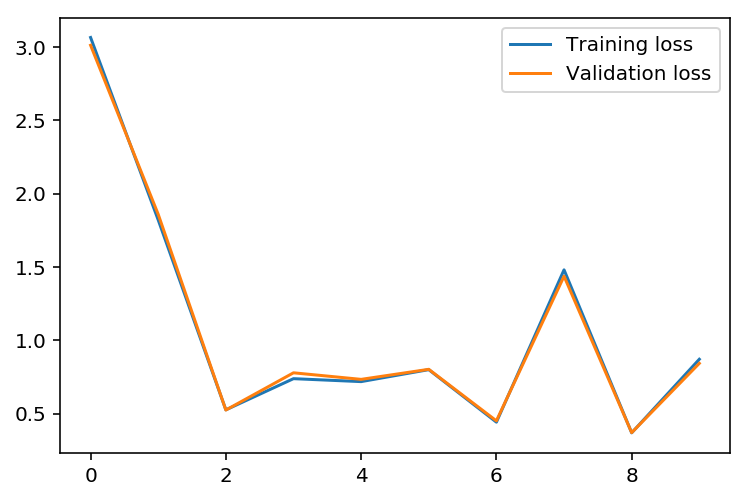

In [55]:
plt.plot(losses['train'], label='Training loss')
plt.plot(losses['validation'], label='Validation loss')
plt.legend()

In [56]:
#testing losses
print('')
print('Performance on Test Data:')
print('')
test_mse_loss = MSE(network.run(test_features), test_targets['cnt'].values)
print('Testing MSE loss: {:.4f}'.format(test_mse_loss))
test_rmse_loss = RMSE(test_targets['cnt'].values, network.run(test_features))
print('Testing RMSE loss: {:.4f}'.format(test_rmse_loss))
test_nrmse_loss = nRMSE(network.run(test_features), test_targets['cnt'].values)
print('Testing nRMSE loss: {:.4f}'.format(test_nrmse_loss))


Performance on Test Data:

Testing MSE loss: 0.6609
Testing RMSE loss: 0.8130
Testing nRMSE loss: 0.9986


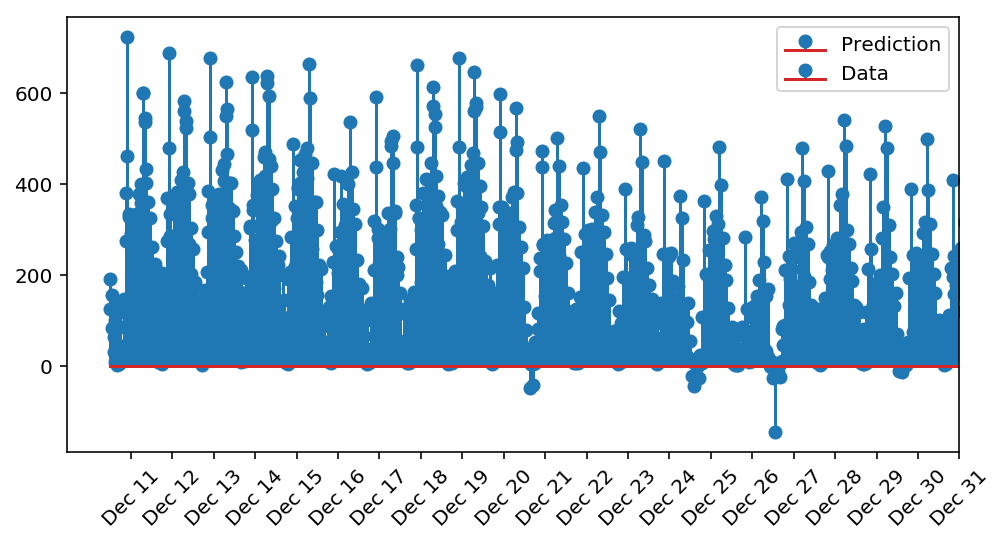

In [59]:
#checking the nn on the test data

fig, ax = plt.subplots(figsize=(8,4))
mean, std = scaled_features['cnt']
predictions = network.run(test_features)*std + mean
ax.stem(predictions[0], label='Prediction')
ax.stem((test_targets['cnt']*std + mean).values, label='Data')
ax.set_xlim(right=len(predictions))
ax.legend()

dates = pd.to_datetime(rides.ix[test_data.index]['dteday'])
dates = dates.apply(lambda d: d.strftime('%b %d'))
ax.set_xticks(np.arange(len(dates))[12::24])
_ = ax.set_xticklabels(dates[12::24], rotation=45)